AMLHC Final Exam Project
Research Question:
Is there a significant relationship between cancer treatment costs and patient survival time, after controlling for age, cancer type, stage, and country?

-> after checking correlation, new features selected 
-> Adjusted research question: Is there a significant relationship between cancer treatment costs and patient survival time, after controlling for Obesity Level, Target Severity Score and Genetic Risk?

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os

In [13]:
# Load dataset
df = pd.read_csv('./data/global_cancer_patients_2015_2024.csv', index_col=0)

# Describe features
print("Dataset overview:")
print(df.describe(include='all')) #Mean value, standard deviation, min/max, frequency for categories

Dataset overview:
                 Age Gender Country_Region          Year  Genetic_Risk  \
count   50000.000000  50000          50000  50000.000000  50000.000000   
unique           NaN      3             10           NaN           NaN   
top              NaN   Male      Australia           NaN           NaN   
freq             NaN  16796           5092           NaN           NaN   
mean       54.421540    NaN            NaN   2019.480520      5.001698   
std        20.224451    NaN            NaN      2.871485      2.885773   
min        20.000000    NaN            NaN   2015.000000      0.000000   
25%        37.000000    NaN            NaN   2017.000000      2.500000   
50%        54.000000    NaN            NaN   2019.000000      5.000000   
75%        72.000000    NaN            NaN   2022.000000      7.500000   
max        89.000000    NaN            NaN   2024.000000     10.000000   

        Air_Pollution   Alcohol_Use       Smoking  Obesity_Level Cancer_Type  \
count    5000

In [ ]:
# Top correlational features
def get_top_correlated_features(df, target_column, k=5):
    correlations = df.corr(numeric_only=True)[target_column].drop(target_column)
    top_features = correlations.abs().sort_values(ascending=False).head(k)
    return top_features
top_corr = get_top_correlated_features(df, target_column='Survival_Years', k=3)
print("Top korrelierende Features:\n", top_corr)

Top korrelierende Features:
 Obesity_Level            0.009739
Target_Severity_Score    0.003850
Genetic_Risk             0.001566
Name: Survival_Years, dtype: float64


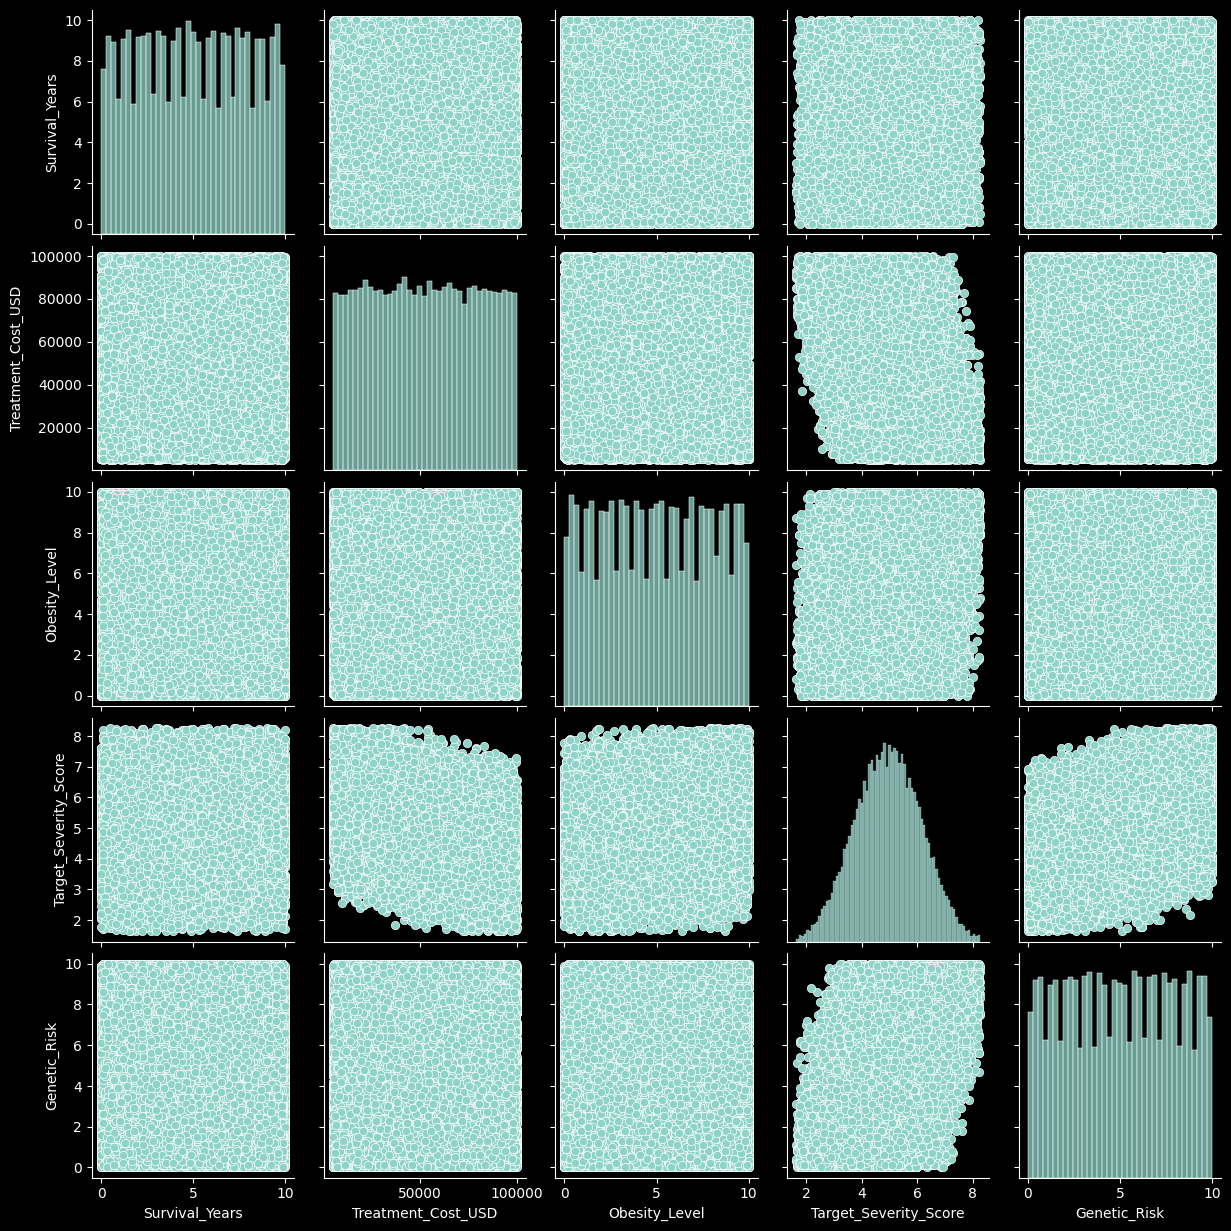

In [ ]:
# Detect and handle outliers using IQR
def iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.where((series >= lower) & (series <= upper), np.nan)

for col in ["Treatment_Cost_USD", "Survival_Years", "Obesity_Level", "Target_Severity_Score", "Genetic_Risk"]:
    df[col] = iqr_outliers(df[col])

# Drop incomplete rows
df.dropna(subset=["Treatment_Cost_USD", "Survival_Years", "Obesity_Level", "Target_Severity_Score", "Genetic_Risk"], inplace=True)

# Visualize pairwise relationships
sns.pairplot(df[["Survival_Years", "Treatment_Cost_USD", "Obesity_Level", "Target_Severity_Score", "Genetic_Risk"]],
             diag_kind="hist", corner=False)

#plt.suptitle("Relationships Between Survival Years, Treatment Cost, Obesity Level, Target Severity Score and Genetic Risk", y=1.02)
plt.show()


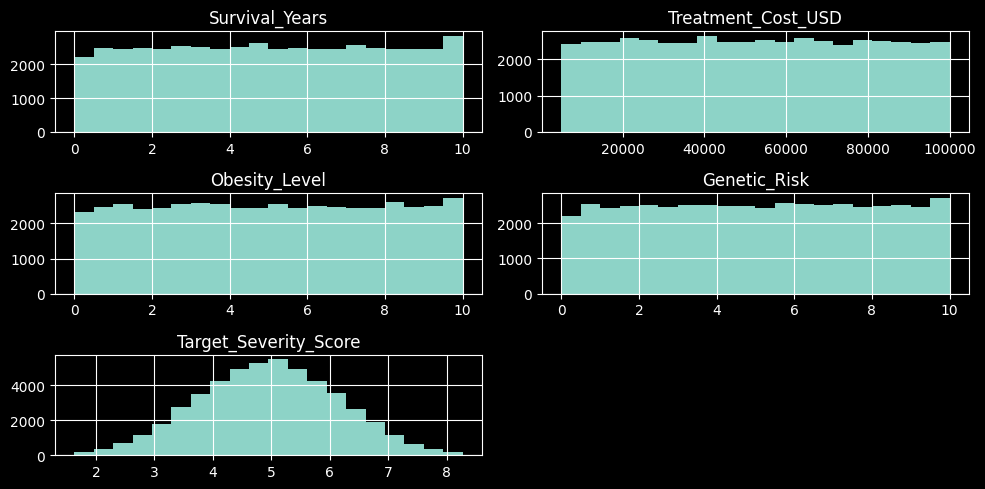

In [8]:
# Histogram plots
df[["Survival_Years", "Treatment_Cost_USD", "Obesity_Level", "Genetic_Risk", "Target_Severity_Score"]].hist(bins=20, figsize=(10, 5))
plt.tight_layout()
plt.show()

Intercept: 4.996717333333333
R^2 score (test set): -0.00015930326540170014
10-Fold Cross-Validation R^2 Scores: [ 2.36277108e-04 -2.04573986e-03 -3.12542184e-04 -3.09084522e-04
 -1.75984569e-04  1.11175446e-05 -3.80587067e-04  2.88077921e-05
 -3.42289766e-04 -6.62402310e-04]
Mean R^2 Score: -0.0003952427831293903


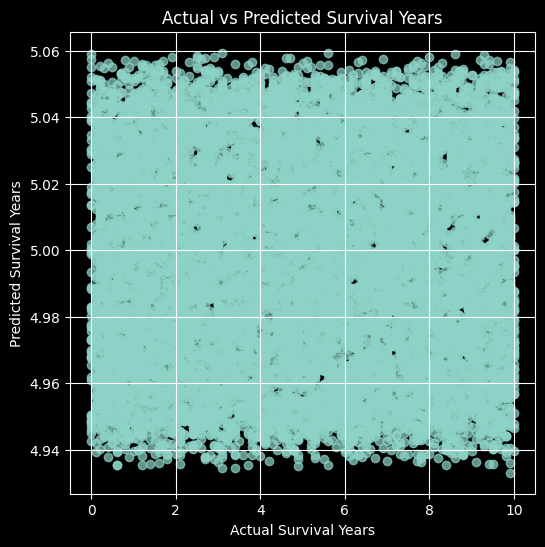

<Figure size 640x480 with 0 Axes>

In [15]:

# Define features and target
features = ["Treatment_Cost_USD", "Obesity_Level", "Genetic_Risk", "Target_Severity_Score"]
target = "Survival_Years"

X = df[features]
y = df[target]

# Preprocessing: Encode categoricals, scale numericals
categorical_features = []
numeric_features = ["Treatment_Cost_USD", "Obesity_Level", "Genetic_Risk", "Target_Severity_Score"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), categorical_features),
    ("num", StandardScaler(), numeric_features)
])

# Build pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)

# Evaluate model
print("Intercept:", pipeline.named_steps['regressor'].intercept_)
print("R^2 score (test set):", r2_score(y_test, pipeline.predict(X_test)))

# Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=10)
print("10-Fold Cross-Validation R^2 Scores:", cv_scores)
print("Mean R^2 Score:", np.mean(cv_scores))

# Scatter plot actual vs predicted
y_pred = pipeline.predict(X_test)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Survival Years")
plt.ylabel("Predicted Survival Years")
plt.title("Actual vs Predicted Survival Years")
plt.grid(True)
plt.show()

# Save plot and results if needed
os.makedirs("results", exist_ok=True)
plt.savefig("results/predicted_vs_actual.png")
